# Extract raw sequences from human genome based on ChIP-exo peak calling data.

The raw ChIP-exo reads are stored in ZNF343.bed, and peaks calling positions data are stored in ZNF343_peaks.bed. 
Both are directly downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2466539

In [ ]:
!bedtools getfasta -fi ../../reference-genomes/hg19/hg19.fa -bed ZNF343_peaks.bed -fo ZNF343_peaks.fa

### Preview of ChIP-exo peak contents

In [1]:
!head -n 6 ZNF343_peaks.fa

>chr1:29096-29378
GGGGCGAGCCCAAGACGCCTCCCGGGCGGTCGGGGCCCAGCGGCGGCGTTCGCAGTGGAGCCGGGCACCGGGCAGCGGCCGCGGAACACCAGCTTGGCGCAGGCTTCTCGGTCAGGAACGGTCCCGGGCCTCCCGCCCGCCTCCCTCCAGCCCCTCCGGGTCCCCTACTTCGCCCCGCCAGGCCCCCACGACCCTACTTCCCGCGGCCCCGGACGCCTCCTCACCTGCGAGCCGCCCTCCCGGAAGCTCCCGCCGCCGCTTCCGCTCTGCCGGAGCCGCTGG
>chr1:714212-714415
CGGCTGCTGAGCTGGCAGTTCTGTGTCGCTAGGCTTCTGCCCGGCCGCCGCCGCACATAAGCCACGAGGAGGAGCTTTACGACTTCCCGGTCTTCGGCGCCGGGCGCAGCAAGGGCCAGACTCTGCGCTAGCAGGCGCTGCGCGCCAACCGGCCGGCACCTGTCGCAGAAGGTGCAACCGATCGCACTGTCGCGCAGAAGCTC
>chr1:740256-740389
ATATCTAAAGGAGGACTCAGAAAACACCGGGGAAGTCCAGCCTGCACGTGGTGGCTGGGCTTCAGTGAAGCATGCAGCACAACAGGAGTTGTAAGTAGTAGTTACATCAGCAGCCCTGGAAATTCTGCTCAGA


# Search for chosen anchor site GAAGCG within all the peak sequences.

In [ ]:
!cat ZNF343_peaks.fa | fasta-grep 'GAAGCG' -dna -f > ZNF343_peaks.extracted

Total of 3237 matches in 4532 sequences


### Preview of list of found anchor sites location within peak sequences.

In [2]:
!head -n 10 ZNF343_peaks.extracted

>chr1:29096-29378:257-262(-) site_0
GAAGCG
>chr1:762405-762630:22-27(+) site_1
GAAGCG
>chr1:1166748-1167195:164-169(+) site_2
gaagcg
>chr1:1166748-1167195:170-175(+) site_3
gaagcg
>chr1:1166748-1167195:186-191(+) site_4
gaagcg


# Using BordersDetector code to count adjacent ChIP-exo reads near individual occurence of anchor site. The detection range is restricted to 40bp either left or right to each anchor site.

![Illustration of anchor site and adjacent regions](img/Anchor_GAAGCG.png)

In [ ]:
import BordersDetector

border_width = 40;
anchor_site  = 'GAAGCG';
forward_shift = 1; # The length of putative protein-binding site to the right of the anchor site;
backward_shift = 30; # The length of putative protein-binding site to the left of the anchor site;

[Forward_counts, Reverse_counts] = BordersDetector.detect(anchors='ZNF343_peaks.extracted', reads='../ZNF343.bed', anchor=anchor_site, border_width = border_width, forward_shift = forward_shift, backward_shift = backward_shift,  output_file='ZNF343.exo')

Total number of sequences:3237
Length of tracked region:86
Average background forward reads per position:118.7
Average background reverse reads per position:148.7
Background value to be subtracted for forward/reverse reads per sequence:1.6	2.1


### Plotting the accumulative ChIP-exo reads distribution near all anchor sites. GAAGCG are prefixed at position 1 to 6.

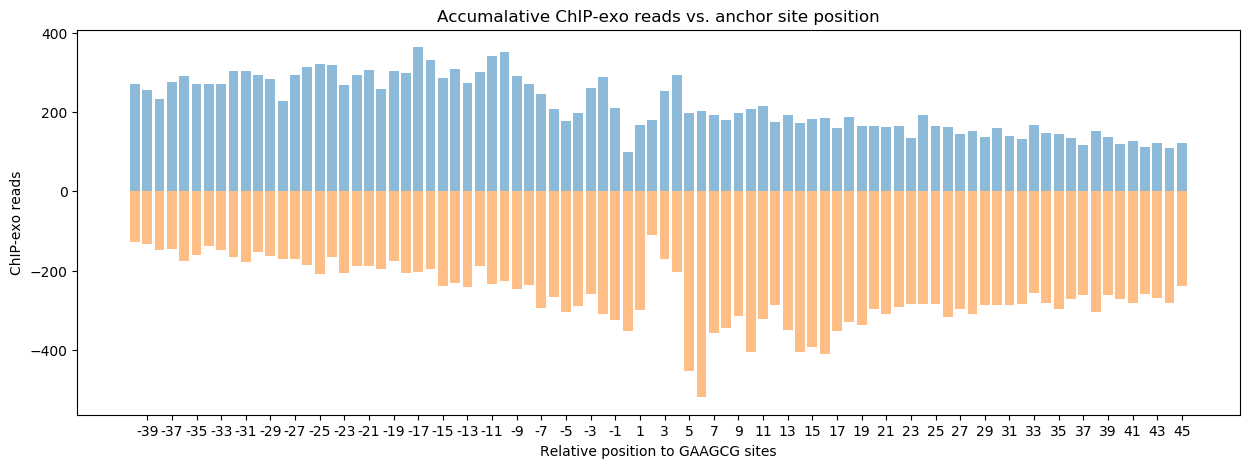

In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

plt.rcParams['figure.figsize'] = [15, 5]

y_pos = np.arange(len(Forward_counts));

xticks_pos = np.arange(1, len(Forward_counts), 2)
xticks = np.arange(-border_width+1, border_width+len(anchor_site)+1, 2);


plt.bar(y_pos, Forward_counts, align='center', alpha=0.5)
plt.xticks(xticks_pos, xticks)
plt.xlabel('Relative position to '+anchor_site+' sites')
plt.ylabel('ChIP-exo reads')
plt.title('Accumalative ChIP-exo reads vs. anchor site position')

plt.bar(y_pos, -1*np.array(Reverse_counts), align='center', alpha=0.5)

plt.show()

### For each individual anchor site, convert the adjacent exo reads into negative logarithmic ratio, which should be proporitional to the binding energy of each underlying sequence.

\begin{align}
{{P}_{i}}=\frac{1}{{{e}^{{({{E}_{i}}-\mu )}/{kT}\;}}+1}\approx {{e}^{-{({{E}_{i}}-\mu )}/{kT}\;}}
\end{align}

where ${P}_{i}$ is the occupancy, or binding probability of TF to some particular site i in the genome, which should be porpotional to the exo reads near site i. In an ideal equilibrium-driven system, the occupancy can be defined by above equation, and approximated as  ${{e}^{-{({{E}_{i}}-\mu )}/{kT}\;}}$ if the protein concentration is sufficiently low. Therefore we can use the negative logarithmic ratio of exo reads near each site i to calculate relative binding energy for data regression and motif analysis.

In [ ]:
import pybedtools as bed
import re, math

bedfn = bed.example_filename('/Volumes/Data drive/ZNF343/Notebook/ZNF343.exo')
myBedTool = bed.BedTool(bedfn)

hg19_fasta = bed.example_filename('/Volumes/Data drive/ZNF343/Notebook/hg19.fa')

myBedTool = myBedTool.sequence(fi=hg19_fasta, s=True, name=True)


seq = '';
count = '';

output = open('ZNF343_'+anchor_site+'.output', 'w');

for line in open(myBedTool.seqfn):
    if line[0] == '>':
        count = int(re.split('>|\(', line)[1]);
   
    else:
        seq   = line[0:len(line)-1];
        if count>0:
            energy = -math.log(count);
        output.write(seq.upper()+'\t'+'%.2f'%energy+'\n');
        
output.close();



### Preview of final output. Sequence + Relative binding energy (kT)

In [ ]:

!head -n 10 ZNF343_GAAGCG.output

GGGCTAGGACCCAGCGGCTCCGGCAGAGCGGAAGCGG	-1.10
ACTCAGGGTCCTGTCTGAGGCGGCCACCCCGAAGCGT	-1.79
CTAACTGGGGATGAGGGTCCACGCGGTTCAGAAGCGG	-1.95
GGGGATGAGGGTCCACGCGGTTCAGAAGCGGAAGCGC	-1.39
GCGGTTCAGAAGCGGAAGCGCAGGCGCAGGGAAGCGG	-1.39
CTGCAGGGACTTTTCCTTCCTCGGAGAGGGGAAGCGG	-1.95
CCGCCCGCCCGCGGCCTTGACAGCCCGGAAGAAGCGG	-1.10
CAGCCGCCGCCCTCCAGCCAGACCGCGCAGGAAGCGG	-0.00
CCCCGGGCCGGACCGCGCTGCCGCAGGAGCGAAGCGG	-1.39
CGGGGCTTGCGGGAAAAGCGAGGGGGAGGAGAAGCGC	-2.08


# Data regression to generate Position Energy Matrix (PEM) or energy logo.
### Website tool used for energy data regression: 
http://stormo.wustl.edu/cgi-bin/gsahota/motif_mlr.pl

Directly copy the content of ZNF343_GAAGCG.output into the website input lane and do regression with default options.

![Relative binding energy data regession result](img/Regression_GAAGCG.png)


### Website tool used for energy logo visualization: 
http://stormo.wustl.edu/EnergyModel/

Copy the PEM info to the website input lane and choose energy matrix option for visualization.

![Energy logo of ZNF343 with prefixed GAAGCG core site](img/Logo_GAAGCG.png)



# Negative control with alternative anchor site(s)

We can perform the same analysis with any alternative anchor site, e.g., tAAGCG, and the resulting motif in the extended region don't match published HT-SELEX and B1H prediction, which lends evidence to our dependent recogition model of ZFPs from another perspective.

![Energy logo of ZNF343 with prefixed TAAGCG core site](img/Logo_TAAGCG.png)

